# Plot GeoTiffs


In this NoteBook the reader finds code to read a GeoTiff file, single- or multi-band, from HDFS. It reads the GeoTiff as a **ByteArray** and then stores the GeoTiff in memory using **MemFile** from **RasterIO** python package. The same package is then used to plot a GeoTiff's band, or multiple bands using sub-plots, histograms, etc. 

With this example the user can load GeoTiffs from HDFS and then explore all the features of Python packages such as [rasterio](https://github.com/mapbox/rasterio). It also show how to run kmeans from [**sklearn**](http://scikit-learn.org/stable/). The kmeans part in this notebook is inpired in [Unsupervised classification of imagery using scikit-learn](http://nbviewer.jupyter.org/gist/om-henners/c6c8d40389dab75cf535).

## Dependencies

In [1]:
#Add all dependencies to PYTHON_PATH
import sys
sys.path.append("/usr/lib/spark/python")
sys.path.append("/usr/lib/spark/python/lib/py4j-0.10.4-src.zip")
sys.path.append("/usr/lib/python3/dist-packages")

#Define environment variables
import os
os.environ["HADOOP_CONF_DIR"] = "/etc/hadoop/conf"
os.environ["PYSPARK_PYTHON"] = "python3"
os.environ["PYSPARK_DRIVER_PYTHON"] = "ipython"

#Load PySpark to connect to a Spark cluster
from pyspark import SparkConf, SparkContext

#from osgeo import gdal
#To read GeoTiffs as a ByteArray
from io import BytesIO
import rasterio
from rasterio.io import MemoryFile

import numpy as np
import matplotlib.pyplot as plt

import sklearn.cluster

## Connect to Spark

In [2]:
appName = "plot_GeoTiff"
masterURL="spark://emma0.phenovari-utwente.surf-hosted.nl:7077"

#A context needs to be created if it does not already exist
try:
    sc.stop()
except NameError:
    print("A  new Spark Context will be created.")
    
sc = SparkContext(conf = SparkConf().setAppName(appName).setMaster(masterURL))

A  new Spark Context will be created.


## Read a GeoTiff file

In [3]:
file_path0 = "hdfs:///user/hadoop/spring-index/BloomFinal/1980.tif"
file_path1 = "hdfs:///user/hadoop/spring-index/BloomFinal/1981.tif"
file_path2 = "hdfs:///user/hadoop/spring-index/BloomFinal/1982.tif"
file_path3 = "hdfs:///user/hadoop/spring-index/BloomFinal/1983.tif"

data0 = sc.binaryFiles(file_path0).take(1)
data1 = sc.binaryFiles(file_path1).take(1)
data2 = sc.binaryFiles(file_path2).take(1)
data3 = sc.binaryFiles(file_path3).take(1)

dataByteArray0 = bytearray(data0[0][1])
dataByteArray1 = bytearray(data1[0][1])
dataByteArray2 = bytearray(data2[0][1])
dataByteArray3 = bytearray(data3[0][1])

memfile0 = MemoryFile(dataByteArray0)
dataset0 = memfile0.open()
memfile1 = MemoryFile(dataByteArray1)
dataset1 = memfile1.open()
memfile2 = MemoryFile(dataByteArray2)
dataset2 = memfile2.open()
memfile3 = MemoryFile(dataByteArray3)
dataset3 = memfile3.open()

## Create NumPy arrays

It will extract the 4th band of each GeoTiff and combine them into a multi-dimensional NumPy array.

In [4]:
#Convert to NumPy array the 4th band
array0 = np.asarray(dataset0.read())[3]
array1 = np.asarray(dataset1.read())[3]
array2 = np.asarray(dataset2.read())[3]
array3 = np.asarray(dataset3.read())[3]

#Remove NaN
array0[np.isnan(array0)] = -1
array1[np.isnan(array1)] = -1
array2[np.isnan(array2)] = -1
array3[np.isnan(array3)] = -1

data = np.array([array0, array1, array2, array3])

## Plot the multi-dimensional array

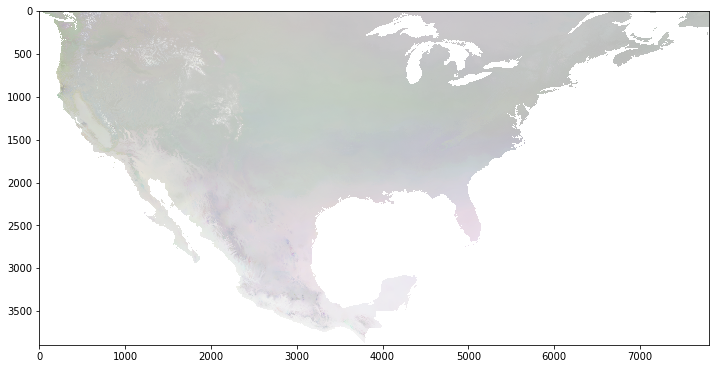

In [9]:
%matplotlib inline

plt.figure(figsize=(12, 12))
plt.imshow(np.dstack(data))

## Re-shape

To work with data in scikit-learn it assumes that your data is in two dimensions, with each row being a sample and each column being a variable. As such you have to reshape your data accordingly.

In [6]:
samples = data.reshape((4, -1)).T
samples.shape

(30388736, 4)

## Kmeans

In [7]:
clf = sklearn.cluster.KMeans(n_clusters=4)
labels = clf.fit_predict(samples)
labels.shape

(30388736,)

## Plot Kmeans clusters

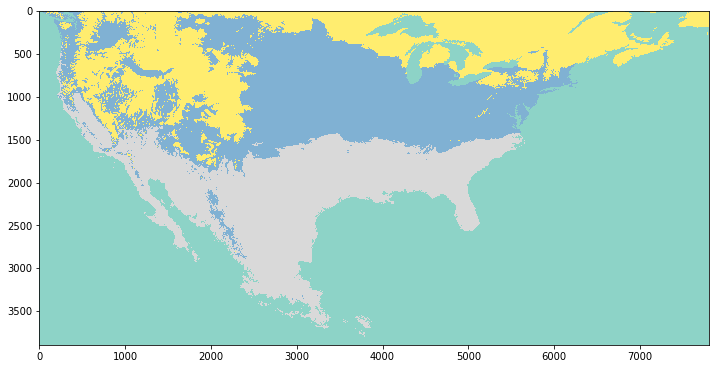

In [8]:
%matplotlib inline

plt.figure(figsize=(12, 12))
plt.imshow(labels.reshape((3892, 7808)), cmap="Set3")